# COGS 108 - EDA Checkpoint

# Names

- James Larsen
- Alejandro Servin
- Lily Steiner
- Mayra Trejo
- Lucy Lennemann

<a id='research_question'></a>
# Research Question

How has the sentiment of the language surrounding Deafness used by popular online news sources (ABC, New York Times, USA Today, The Guardian, Associated Press) changed since the 80s?

# Setup

In [1]:
#import necessary packages, some will be used during analysis
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import unicodedata
import nltk
from textblob import TextBlob, Word
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
from datetime import date
from collections import defaultdict
import math
import gensim
from gensim import corpora
import string
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /home/jamie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jamie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Import Datasets
# Import ABC Dataset
with open('dataset/abc_data.json') as abc_ds:
    abc_data=json.load(abc_ds)
    
# Import Alternative Press Dataset
with open('dataset/ap_data.json') as ap_ds:
    ap_data=json.load(ap_ds)

# Import The Guardian Dataset
with open('dataset/guard_data.json') as guard_ds:
    guard_data=json.load(guard_ds)
    
# Import New York Times Dataset
with open('dataset/nyt_data.json') as nyt_ds:
    nyt_data=json.load(nyt_ds)

# Import USA Today Dataset
with open('dataset/usa_data.json') as usa_ds:
    usa_data=json.load(usa_ds)

In [3]:
# Convert datasets to dataforms
abc_df = pd.read_json('dataset/abc_data.json')
ap_df = pd.read_json('dataset/ap_data.json') 
guard_df = pd.read_json('dataset/guard_data.json')
nyt_df = pd.read_json('dataset/nyt_data.json') 
usa_df = pd.read_json('dataset/usa_data.json') 

In [4]:
# Set row and column display
pd.options.display.max_rows=6
pd.options.display.max_columns=5

#Used to look for text errors reverted for cleaning
#pd.options.display.max_colwidth=None 

pd.options.display.max_colwidth=40

In [5]:
#Space for textblob coode

# Data Cleaning

Describe your data cleaning steps here.

1. We are reordering the columns of all the dataframes so that they match.
2. We are converting the date strings into pd.datetime format
3. We are removing all articles before 1980-01-01
4. We are removing unicode artifacts from the text using unicodedata.normalize
5. We are removing any extraneous articles
6. We are removing any extraneous pieces of article text

### ABC Dataset

In [6]:
#visualize dataframe
abc_df                                      

,url,headline,source,date,text
0,https://abcnews.go.com/US/wireStory/...,Prosecutor: Alex Murdaugh now faces ...,ABC News,2022-01-21 18:17:00,"COLUMBIA, S.C. -- A once-prominent S..."
1,https://abcnews.go.com/US/undefeated...,Undefeated: Deaf football team bring...,ABC News,2021-11-20 12:59:00,"Once considered underdogs, the footb..."
2,https://abcnews.go.com/US/referee-ac...,Referee accused of discriminating ag...,ABC News,2021-12-30 02:53:00,The American Civil Liberties Union i...
...,...,...,...,...,...
158,https://abcnews.go.com/US/dunwoody-d...,Dunwoody Day Care Trial: Widow 'Didn...,ABC News,2012-02-24 16:02:00,"ATLANTA, Feb. 24, 2012 — -- A witnes..."
159,https://abcnews.go.com/US/story?id=9...,Police Investigate Deaf Student Homi...,ABC News,2006-01-07 15:05:00,"Feb. 4, 2001 -- A student found dead..."
160,https://abcnews.go.com/US/story?id=9...,Rush Limbaugh Suffers Hearing Loss -...,ABC News,2006-01-07 15:26:00,"Oct. 8, 2001 -- Rush Limbaugh, who's..."


In [7]:
# Reorganize columns
abc_df = abc_df[['headline','date','source','url','text']]

# Convert 'date' to datetime format and only visualize date
abc_df['date'] = pd.to_datetime(abc_df['date'], errors='coerce')

# Remove articles before 1980-01-01
abc_df = abc_df[~(abc_df['date']<='1980-01-01')]

abc_df['source'] = 'abc'

In [8]:
#look for null values
abc_df.isnull().sum()

headline    0
date        0
source      0
url         0
text        0
dtype: int64

In [9]:
#Comb for unique values in the 'headline' column
abc_df['headline'].unique()

array(['Prosecutor: Alex Murdaugh now faces 71 charges; $8.5M stolen ...',
       'Undefeated: Deaf football team brings triumph and pride to ...',
       'Referee accused of discriminating against deaf wrestler in state ...',
       'Preserving Black American Sign Language in the Deaf community ...',
       'Baby born deaf has touching reaction to hearing music for 1st time ...',
       "Deaf Costco worker with mumbling manager won't get award - ABC ...",
       'Today in History - ABC News',
       "Scenes from Week 1 of Ghislaine Maxwell's sex-abuse trial - ABC ...",
       'Police officer dies from COVID-19 just 3 months after retirement ...',
       'Man released from prison after 48 years in court compromise - ABC ...',
       'Liberty Univ associate professor charged with sexual battery - ABC ...',
       'Report Warns of Terror Unpreparedness - ABC News',
       "Epstein's former house manager testifies, calls Ghislaine Maxwell ...",
       "Nobel doctor calls sexual violence i

In [10]:
#Clean text
abc_df['text'] = abc_df['text'].apply(lambda t: unicodedata.normalize('NFKD', t))

### Associated Press Dataset

In [11]:
#visualize dataframe
ap_df 

,url,headline,date,source,text
0,https://apnews.com/article/lifestyle...,2 hurt when part of student center c...,2022-01-13 12:53:56+00:00,AP News,"TALLADEGA, Ala. (AP) — Two workers w..."
1,https://apnews.com/article/georgia-u...,Georgia hospital agrees to measures ...,2022-01-09 15:58:08+00:00,AP News,"CALHOUN, Ga. (AP) — Federal authorit..."
2,https://apnews.com/article/sports-ba...,Wednesday's Scores | AP News,2022-01-27 05:20:44+00:00,AP News,"BOYS PREP BASKETBALL=Ash Fork 50, Gr..."
...,...,...,...,...,...
374,https://apnews.com/article/7bd22eafb...,Blind Lobby for Bill to Ban Seating ...,1990-02-07 07:41:00+00:00,AP News,\t WASHINGTON (AP) _ Scores of bli...
375,https://apnews.com/article/048cc469c...,Judaism in Silence: New Sign Languag...,1985-05-07 18:06:00+00:00,AP News,"\t NEWARK, N.J. (AP) _ Naomi Mille..."
376,https://apnews.com/article/03d6ff92f...,No One Took Girl's Threats Seriously...,1985-12-04 19:16:00+00:00,AP News,"\t SPANAWAY, Wash. (AP) _ Danny Ga..."


In [12]:
# Reorganize columns
ap_df = ap_df[['headline','date','source','url','text']]

# Convert 'date' to datetime format and only visualize date
ap_df['date'] = pd.to_datetime(ap_df['date'])

#Remove articles before 1980-01-01
ap_df = ap_df[~(ap_df['date']<='1980-01-01')]

ap_df['source'] = 'ap'

In [13]:
# Look for null values
ap_df.isnull().sum()

headline    0
date        0
source      0
url         0
text        0
dtype: int64

In [14]:
#Comb for unique values in the 'headline' column
ap_df['headline'].unique()

array(['2 hurt when part of student center collapses at deaf school | AP News',
       'Georgia hospital agrees to measures to help deaf patients | AP News',
       "Wednesday's Scores | AP News",
       'New NYC mayor says kids safe in school despite virus surge | AP ...',
       "Tuesday's Scores | AP News", "Monday's Scores | AP News",
       "Saturday's Scores | AP News", "Thursday's Scores | AP News",
       "Friday's Scores | AP News",
       'Mickey Guyton, Jhené Aiko, Mary Mary to sing at Super Bowl | AP ...',
       'Omicron surge is undermining care for other health problems | AP ...',
       'West Virginia lawmakers introduce 15-week abortion ban | AP News',
       'Ómicron trastoca el regreso a las escuelas en EEUU | AP News',
       'Prosecutor: Alex Murdaugh now faces 71 charges; $8.5M stolen | AP ...',
       'What to watch out for when Oscar noms are announced Tuesday ...',
       'New this week: Mary J. Blige, Jennifer Lopez and Puppy Bowl | AP ...',
       '2022 SAG n

In [15]:
#Remove articles that report sports scores
ap_df = ap_df[ap_df['headline'].str.contains("Monday's Scores|Tuesday's Scores|Wednesday's Scores|Thursday's Scores|Friday's Scores|Saturday's Scores|Sunday's Scores")==False]

#Clean text
ap_df['text'] = ap_df['text'].apply(lambda t: unicodedata.normalize('NFKD', t))

### The Guardian Dataset

In [16]:
#visualize dataframe
guard_df

,url,date,source,headline,text
0,https://www.theguardian.com/society/...,2022-01-27 19:51:16+00:00,The Guardian,British Sign Language to become reco...,British Sign Language (BSL) is on co...
1,https://www.theguardian.com/society/...,2021-12-09 18:10:02+00:00,The Guardian,Scottish health board apologises ove...,A Scottish health board has apologis...
2,https://www.theguardian.com/tv-and-r...,2022-01-10 17:36:39+00:00,The Guardian,Strictly: sign language interpreter ...,She was the first deaf contestant an...
...,...,...,...,...,...
6838,https://www.theguardian.com/theguard...,1954-11-12 15:10:17+00:00,The Guardian,Pensioners demand £2 10s a week - fr...,About four thousand old age pensione...
6839,https://www.theguardian.com/theobser...,1932-05-22 13:38:00+00:00,The Guardian,First woman to fly the Atlantic,"Miss Amelia Earhart, the American fl..."
6840,https://www.theguardian.com/world/18...,1865-02-07 02:35:09+00:00,The Guardian,Beethoven conducts Fidelio,Extracts from Louis Spohr's autobiog...


In [17]:
# Reorganize columns
guard_df = guard_df[['headline','date','source','url','text']]

# Convert 'date' to datetime format and only visualize date
guard_df['date'] = pd.to_datetime(guard_df['date'])

#Remove articles before 1980-01-01
guard_df = guard_df[~(guard_df['date']<='1980-01-01')]

guard_df['source'] = 'guard'

In [18]:
# Look for null values
guard_df.isnull().sum()

headline    0
date        0
source      0
url         0
text        0
dtype: int64

In [19]:
#Comb for unique values in the 'headline' column
guard_df['headline'].unique()

array(['British Sign Language to become recognised language in the UK ',
       'Scottish health board apologises over late diagnosis of deaf children',
       'Strictly: sign language interpreter to be projected on to big screens at live shows',
       ..., 'Yours sincerely, FG Pink', 'Revenge of the old guard',
       "Magus's maggot"], dtype=object)

In [20]:
#Clean text
guard_df['text'] = guard_df['text'].apply(lambda t: unicodedata.normalize('NFKD', t))

### New York Times Dataset

In [21]:
#visualize dataframe
nyt_df                                    

,url,headline,date,source,text
0,https://www.nytimes.com/2021/11/19/p...,How the Beatles Broke Up and the Dea...,2021-11-19 10:30:02+00:00,The New York Times,"This weekend, listen to a collection..."
1,https://www.nytimes.com/2021/10/10/o...,Don’t Fear a Deafer Planet,2021-10-10 15:00:07+00:00,The New York Times,"In Deaf culture, we have a rich stor..."
2,https://www.nytimes.com/2021/10/01/s...,"R. Allen Gardner, 91, Dies; Taught S...",2021-10-01 16:37:51+00:00,The New York Times,Washoe was 10 months old when her fo...
...,...,...,...,...,...
744,https://www.nytimes.com/1985/07/29/o...,Where Chimpanzees Use Sign Language,1985-07-29 05:00:00+00:00,The New York Times,Credit...The New York Times Archives...
745,https://www.nytimes.com/1984/02/06/o...,FIRE ALARMS FOR THE DEAF,1984-02-06 05:00:00+00:00,The New York Times,Credit...The New York Times Archives...
746,https://www.nytimes.com/1982/07/22/o...,DEAF AND SAFE DRIVERS,1982-07-22 05:00:00+00:00,The New York Times,Credit...The New York Times Archives...


In [22]:
# Reorganize columns
nyt_df = nyt_df[['headline','date','source','url','text']]

# Convert 'date' to datetime format and only visualize date
nyt_df['date'] = pd.to_datetime(nyt_df['date'])

#Remove articles before 1980-01-01
nyt_df = nyt_df[~(nyt_df['date']<='1980-01-01')]

nyt_df['source'] = 'nyt'

# Visualize 'text' to search for errors
#nyt_df['text']

In [23]:
#Look for null values
nyt_df.isnull().sum()

headline    0
date        0
source      0
url         0
text        0
dtype: int64

In [24]:
#Comb for unique values in the 'headline' column
nyt_df['headline'].unique()

array(['How the Beatles Broke Up and the Deaf Football Team Taking California by Storm: The Week in Narrated Articles',
       'Don’t Fear a Deafer Planet',
       'R. Allen Gardner, 91, Dies; Taught Sign Language to a Chimp Named Washoe',
       'Barbara Kannapell, Activist Who Empowered Deaf People, Dies at 83',
       'Lesson of the Day: ‘Black, Deaf and Extremely Online’',
       'Black, Deaf and Extremely Online',
       'I Think Beethoven Encoded His Deafness in His Music',
       'Mothering While Deaf in a Newly Quiet World',
       'A Deaf-Blind Dishwasher Achieves His Childhood Dream: Movie Actor',
       'The Queer, Half-Deaf Actor Redefining the Idea of a Leading Man',
       'Giannis Antetokounmpo Is Called Amazing. Now in Sign Language, Too.',
       'University Denounced for Showing Sign Language for ‘Jewish’ as a Hooked Nose',
       'Harlan Lane, Vigorous Advocate for Deaf Culture, Dies at 82',
       'At Banks and Fund Firms, Access Is Too Often Denied, Blind and Deaf 

### USA Today Dataset

In [25]:
#create dataframe using dataset

#visualize dataframe
usa_df 

,url,headline,source,date,text
0,https://www.usatoday.com/story/enter...,"Deaf Detroit rapper to join Eminem, ...",USA Today,"Published: 8:16 p.m. ET Feb. 4, 2022...",Sean Forbes had expected to experien...
1,https://www.usatoday.com/story/news/...,"Black, deaf, proud: Gallaudet Univer...",USA Today,"Published: 5:01 a.m. ET Feb. 3, 2022...",WASHINGTON – It’s a chilly December ...
2,https://www.usatoday.com/story/money...,Reviewed launches new vertical dedic...,USA Today,"Published: 8:58 a.m. ET Jan. 10, 202...",— Recommendations are independently ...
...,...,...,...,...,...
1323,https://www.usatoday.com/story/popca...,Early Buzz: Post-Halloween treats,USA Today,"Published: 10:49 a.m. ET Nov. 1, 201...","Happy November, Pop Readers! I can't..."
1324,https://www.usatoday.com/story/enter...,Singer who lost hearing while attend...,USA Today,"Published: 12:26 p.m. ET June 7, 201...",Mandy Harvey's voice was heard aroun...
1325,https://www.usatoday.com/story/news/...,Daughters of man killed by police sp...,USA Today,"Published: 6:27 p.m. ET Sept. 29, 20...",After hearing that Louisville Metro ...


In [26]:
# Reorganize columns
usa_df = usa_df[['headline','date','source','url','text']]

# Convert 'date' to datetime format and only visualize date
pd.options.mode.chained_assignment = None

usa_df['date'] = usa_df['date'].str.extract(r'Published:? (.*?)(?:Updated:?.*)?$')
usa_df['date'] = usa_df['date'].str.replace('ET', '')
usa_df['date'] = pd.to_datetime(usa_df['date'])

pd.options.mode.chained_assignment = 'warn'

# Remove articles before 1980-01-01
usa_df = usa_df[~(usa_df['date']<='1980-01-01')]

usa_df['source'] = 'usa'

#Find data types
usa_df.dtypes

headline            object
date        datetime64[ns]
source              object
url                 object
text                object
dtype: object

In [27]:
#look for null values
print(usa_df.isnull().sum())
usa_df.dropna(inplace=True)

headline    0
date        4
source      0
url         0
text        0
dtype: int64


In [28]:
#Comb for unique values in the 'headline' column
usa_df['headline'].unique()

array(['Deaf Detroit rapper to join Eminem, Dre, Snoop at Super Bowl halftime',
       'Black, deaf, proud: Gallaudet University embraces all of its diversity',
       'Reviewed launches new vertical dedicated to accessibility', ...,
       'Early Buzz: Post-Halloween treats',
       "Singer who lost hearing while attending CSU wows America's Got ...",
       'Daughters of man killed by police speak out'], dtype=object)

In [29]:
#Clean Text
usa_df['text'] = usa_df['text'].apply(lambda t: unicodedata.normalize('NFKD', t))

# Data Analysis & Results (EDA)

Checking to see how many articles we have per year

<AxesSubplot:xlabel='year', ylabel='count'>

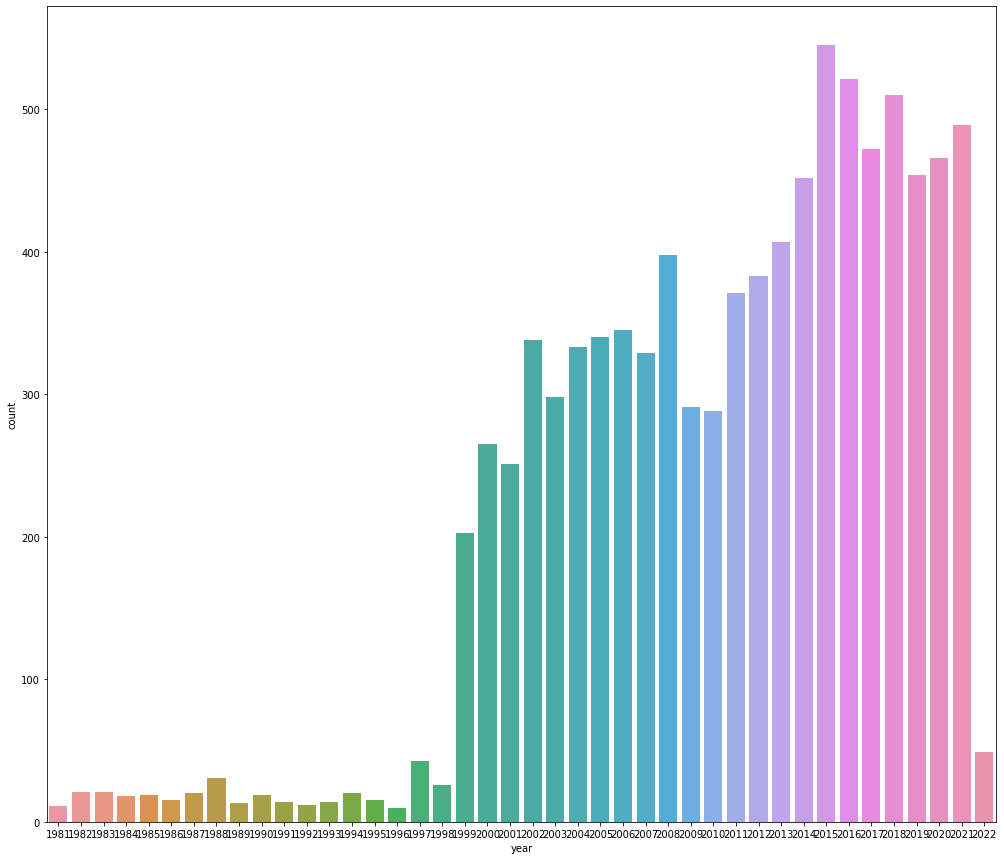

In [32]:
plt.rcParams['figure.figsize'] = (17, 15)

sns.countplot(data=combined_df, x='year')

We'll have to keep in mind that our data is much denser for 1999 onwards than for 1981-1998

## Generating Sentiment Analysis Scores

In this next section, we are creating new dataframes which will have the analysis results in addition to defining a few helper functions for our analysis. 

In [33]:
#find sentiment for a given piece of text
def get_sentiment(text):
    blob = TextBlob(text)
    polarity, subjectivity = blob.sentiment
    return polarity, subjectivity

In [34]:
#cleans text and returns textblob object for keyword analysis 
def cleaned_blob(text):    
    #removes all quotations, periods, commas, and hyphens
    text = text.replace('‘', '')
    text = text.replace('’', '')
    text = text.replace('“', '')
    text = text.replace('”', '')
    text = text.replace('.', ' ')
    text = text.replace(',', ' ')
    text = text.replace('–', ' ')   
    text = text.replace('-', ' ')
    #removes stopwords 
    words_list = (x for x in TextBlob(text).words if x not in stopwords.words('English'))
    #removes numbers, not relevant for keyword analysis
    words_list = (x for x in words_list if x.isalpha())
    #lemmatizes
    words_list = (Word(word).lemmatize() for word in words_list)
    # joins all words into one string
    cleaned = ' '.join(words_list)
    b = TextBlob(cleaned) 
    #remove leading/trailing whitespace and makes all lowercase
    b = b.strip()
    b = b.lower()
    return b

Now we will apply this function to each news dataframe and add two columns with the objectivity score and subjectivity score (polarity ranging from -1 to 1 and subjectivity from 0 to 1) 

In [35]:
news_data_sent = [abc_df, ap_df, guard_df, nyt_df, usa_df]
for df in news_data_sent:
    df[['polarity', 'subjectivity']]=df.apply(lambda x: get_sentiment(x['text']),axis=1,
                             result_type='expand')

In [36]:
#test to see if properly configured
abc_df

,headline,date,...,polarity,subjectivity
0,Prosecutor: Alex Murdaugh now faces ...,2022-01-21 18:17:00,...,0.066518,0.394252
1,Undefeated: Deaf football team bring...,2021-11-20 12:59:00,...,0.117981,0.488425
2,Referee accused of discriminating ag...,2021-12-30 02:53:00,...,0.054921,0.421270
...,...,...,...,...,...
158,Dunwoody Day Care Trial: Widow 'Didn...,2012-02-24 16:02:00,...,0.000680,0.437609
159,Police Investigate Deaf Student Homi...,2006-01-07 15:05:00,...,0.074857,0.390068
160,Rush Limbaugh Suffers Hearing Loss -...,2006-01-07 15:26:00,...,0.066071,0.438921


We're now combining all the different dataframe into one unified dataframe. We're also making a column specifically for the year in which the article was published for easier graphing.

In [37]:
# List of dataframes for function iteration
df_list = [abc_df, ap_df, guard_df, nyt_df, usa_df]

In [38]:
combined_df = pd.concat(df_list).reset_index(drop=True)
combined_df['year'] = combined_df['date'].apply(lambda d: d.year)
combined_df

,headline,date,...,subjectivity,year
0,Prosecutor: Alex Murdaugh now faces ...,2022-01-21 18:17:00,...,0.394252,2022
1,Undefeated: Deaf football team bring...,2021-11-20 12:59:00,...,0.488425,2021
2,Referee accused of discriminating ag...,2021-12-30 02:53:00,...,0.421270,2021
...,...,...,...,...,...
9137,Early Buzz: Post-Halloween treats,2012-11-01 10:49:00,...,0.467978,2012
9138,Singer who lost hearing while attend...,2017-06-07 12:26:00,...,0.405035,2017
9139,Daughters of man killed by police sp...,2016-09-29 18:27:00,...,0.397457,2016


## Overview of Sentiment Analysis Results 

Barplot showing the average polarity scores and sentiments by news source. USA is the most positive in terms of polarity. Overall, we can see a slightly positive sentiment. In terms of subjectivity, we can see that for the most part all the sources are on the more objective side since they are less than 0.5, with Gaurdian being the most subjective.

<AxesSubplot:title={'center':'Polarity'}, xlabel='source', ylabel='polarity'>

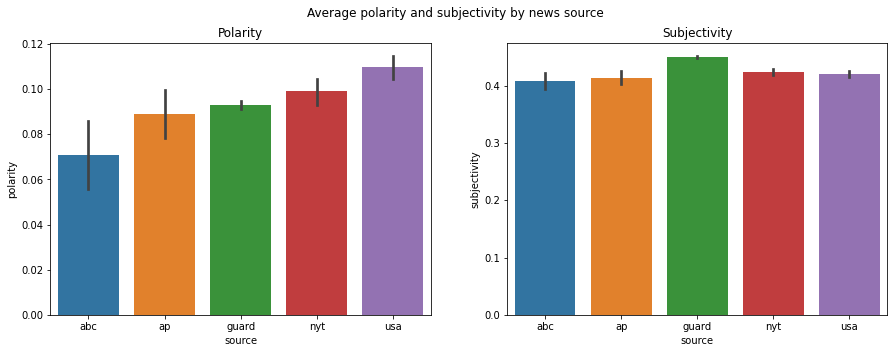

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Average polarity and subjectivity by news source')
axes[1].set_title('Subjectivity')
axes[0].set_title('Polarity')
sns.barplot(ax=axes[1],x=combined_df['source'], y=combined_df['subjectivity'])
sns.barplot(ax=axes[0],x=combined_df['source'], y=combined_df['polarity'])   

 Visualization of the distribution of polarity vs subjectivity. We see a few outliers, mostly from USA. Generally we can see the overall trend again of our articles having a more positive sentiment and being less subjective. 

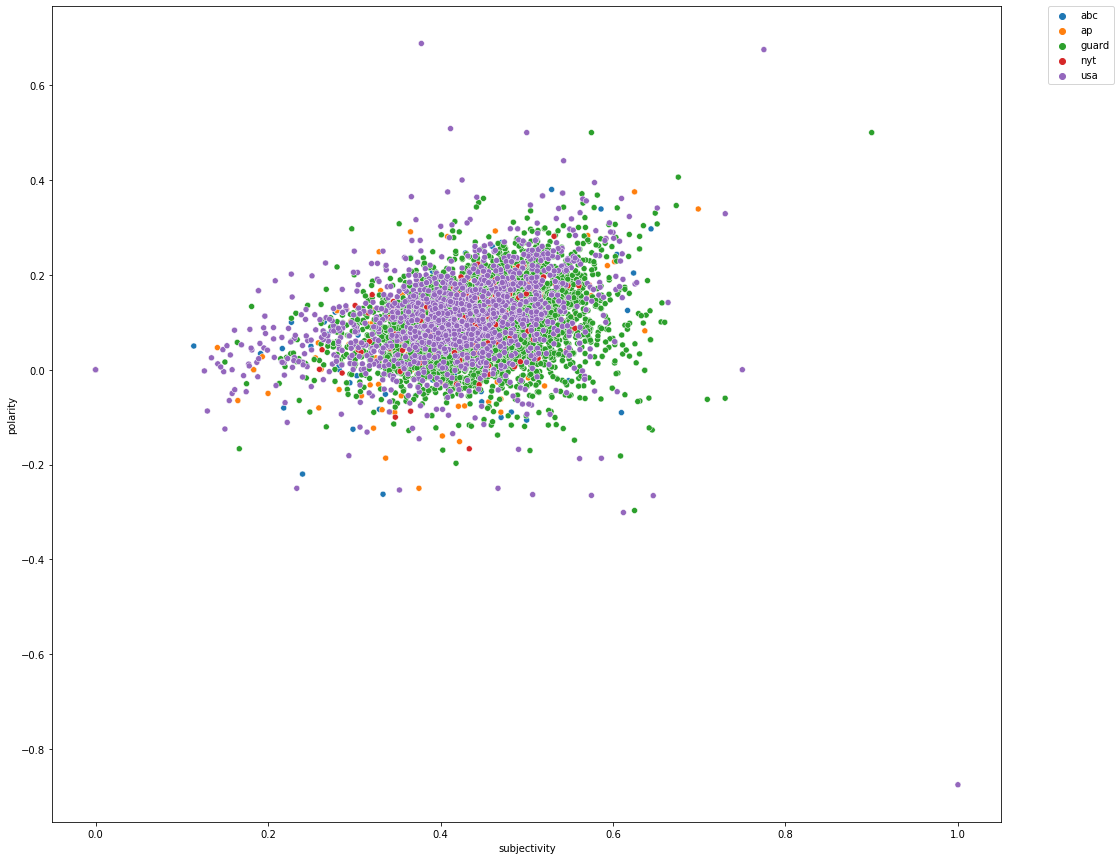

In [40]:
sns.scatterplot(data=combined_df[combined_df['year'] >= 2008], x='subjectivity', y='polarity', hue='source')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Next we will look at this data over time. The following are lineplots showing the polarity and sentiment over time for each news source.

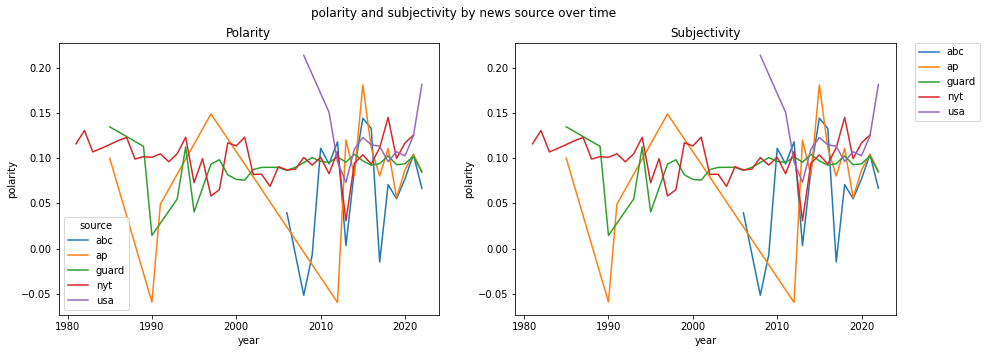

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('polarity and subjectivity by news source over time')
axes[1].set_title('Subjectivity')
axes[0].set_title('Polarity')
sns.lineplot(ax=axes[0], data=combined_df, x='year', y='polarity', hue='source', ci=None)
sns.lineplot(ax=axes[1], data=combined_df, x='year', y='polarity', hue='source', ci=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Since some of our news sources don't have articles as far back, we'll take a closer look with the minimum year being 2008. 

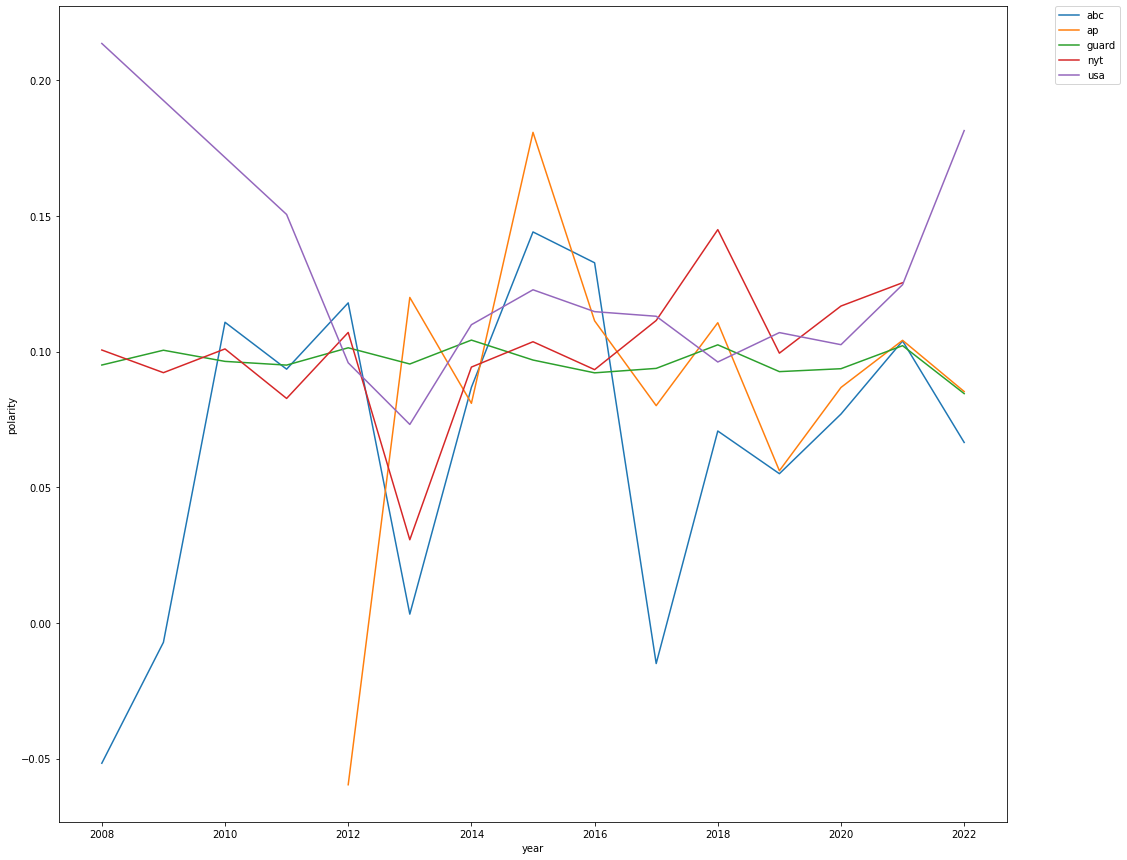

In [42]:
sns.lineplot(data=combined_df[combined_df['year'] >= 2008], x='year', y='polarity', hue='source', ci=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Some of these years have scores are relatively low in comparison, so we will investigate these. First we will look at the 1990 AP and Guardian articles from the previous figure. Next we will explore the dip in ABC, NYT, and USA in 2013. 

In [43]:
#investigate dips in 1990 AP and guard articles:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.max_colwidth = 130
combined_df[(combined_df['year'] == 1990) & ((combined_df['source'] == 'ap') | (combined_df['source'] == 'guard'))]

,headline,date,source,url,text,polarity,subjectivity,year
409,ANOTHER LOOK: White Supremacist Posse Comitatus Fades Into ...,1990-09-10 04:07:00+00:00,ap,https://apnews.com/article/f11b9a11163961c6a81666e4dfdc1625,"\t TIGERTON, Wis. (AP) _ Delbert Larson scanned the empty woods where the Posse Comitatus once envisioned a paramilitary set...",-0.033320,0.442262,1990
410,Blind Lobby for Bill to Ban Seating Limitations on Airliners | AP News,1990-02-07 07:41:00+00:00,ap,https://apnews.com/article/7bd22eafb2685016dd201f62fdf22bea,\t WASHINGTON (AP) _ Scores of blind people are lobbying Congress to overturn a proposed Federal Aviation Administration rul...,-0.084977,0.477494,1990
7248,"Yours sincerely, FG Pink",1990-04-11 01:07:37+00:00,guard,https://www.theguardian.com/society/1990/apr/11/guardiansocietysupplement,"At the age of 60, when other men would be winding down or already retired, he is not only working 11 1/2-hour night shifts, bu...",0.014540,0.490090,1990


Looking at the following articles, it makes sense there was a low sentiment for each. One discusses an ableist bill being passed by Congress, and the others use ableist language with respect to the Deaf community. There is only one article from the Guardian and 2 from AP for this year, which limits the ability to make a generalized statement about the sentiment surrounding the Deaf community during this era. Considering that these are the only articles we have for this year by these two sources, and all are negatively related to the Deaf, it would be good to consider this moving forward in terms of our research question. 

Lets explore the dip in ABC, NYT, and USA in 2013.

In [44]:
#~2013 NYT and ABC and USA
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.max_colwidth = 130
#get a subset of all articles from these specific news sources that have a less than 0 polarity from the year 2013
combined_df[(combined_df['polarity'] < 0) & (combined_df['year'] == 2013) & ((combined_df['source'] == 'nyt') | (combined_df['source'] == 'usa') | (combined_df['source'] == 'abc'))]

,headline,date,source,url,text,polarity,subjectivity,year
127,Deaf Man Stabbed After Sign Language Mistaken for Gang Signs ...,2013-01-14 20:21:00,abc,https://abcnews.go.com/US/deaf-man-stabbed-sign-language-mistaken-gang-signs/story?id=18213488,"Jan 14, 2013— -- A deaf man in North Carolina, communicating to a friend via sign language, was stabbed multiple times after h...",-0.125427,0.298504,2013
129,Deaf Texas Parents Allegedly Kill Crying Baby - ABC News,2013-05-01 14:20:00,abc,https://abcnews.go.com/US/deaf-texas-parents-allegedly-kill-crying-baby/story?id=19082627,"May 1, 2013 — -- A deaf Texas couple have been charged in the beating death of their 5-month-old daughter who was allegedly ki...",-0.083373,0.329059,2013
7596,Art Comes to the Interstate,2013-09-24 14:30:18+00:00,nyt,https://tmagazine.blogs.nytimes.com/2013/09/24/on-view-art-comes-to-the-interstate/,"\n \n A detail from Shana Lutker’s series “Onward and Upward,” for M...",-0.100000,0.347619,2013
7598,Nebraska: Deaf Student Wins,2013-09-05 03:57:00+00:00,nyt,https://www.nytimes.com/2013/09/05/us/nebraska-deaf-student-wins.html,Creighton University violated the Americans with Disabilities Act and the Rehabilitation Act when it failed to provide accomm...,-0.166667,0.433333,2013
7600,Deaf Patrons’ Suit Accuses Starbucks of Discrimination,2013-08-08 21:07:41+00:00,nyt,https://www.nytimes.com/2013/08/09/nyregion/suit-accuses-new-york-starbucks-of-discriminating-against-deaf-patrons.html,"The Starbucks coffee shop on Astor Place is an airy, communal retreat where the regulars huddle with their laptops, reconnect ...",-0.030246,0.418780,2013
9051,WH: No comment on Obama's sign language interpreter,2013-12-11 12:47:00,usa,https://www.usatoday.com/story/theoval/2013/12/11/obama-sign-language-interpreter-south-africa-nelson-mandela-memorial/3987539/,The White House is declining to comment on reports in South Africa that the man who provided alleged sign interpretation of Pr...,-0.054545,0.362626,2013
9052,Mandela memorial interpreter used bogus signs before,2013-12-12 04:06:00,usa,https://www.usatoday.com/story/news/world/2013/12/12/mandela-sign-language-interpreter-thamsanqa-jantjie/3995875/,Thamsanqa Jantjie says he suffered schizophrenic episodeSouth Africa is investigating the allegationsJantjie was paid %2485 to...,-0.072412,0.502418,2013
9056,Interpreter at Mandela memorial branded 'fake',2013-12-11 06:21:00,usa,https://www.usatoday.com/story/news/world/2013/12/11/mandela-south-africa-deaf-fake/3985257/,"Government is investigating the allegationPRETORIA, South Africa -- The sign language interpreter used at Tuesday's memorial s...",-0.186667,0.586528,2013
9062,Deaf man stabbed when sign language seen as gang signs,2013-01-11 20:06:00,usa,https://www.usatoday.com/story/news/nation/2013/01/11/deaf-man-stabbed/1828077/,The victim is in stable condition.He was stabbed several times with a kitchen knifeHis attacker faces multiple charges includi...,-0.087037,0.129630,2013
9064,Report: S. African interpreter charged with murder in 2003,2013-12-13 10:35:00,usa,https://www.usatoday.com/story/news/world/2013/12/13/south-africa-sign-language-interpreter/4009717/,"The South African government says it is investigating the 'fake' sign language interpreter at Nelson Mandela's memorial, accor...",-0.134783,0.414130,2013


Looking at these results, one commmon thing we can observe is that the event where an unqualified sign interpreter was present at a memorial for Nelson Mandela has an overall low polarity score and is the subject of many of these articles (6 total)

### Looking for outliers

With the following graphs, we graphed the distribution of the variable polarity separated by news source. The polarity represents the degree of sentiment from -1 to 1, -1 being very negative and 1 being very positive. We also included a dotted line to indicate the mean of each distribution.

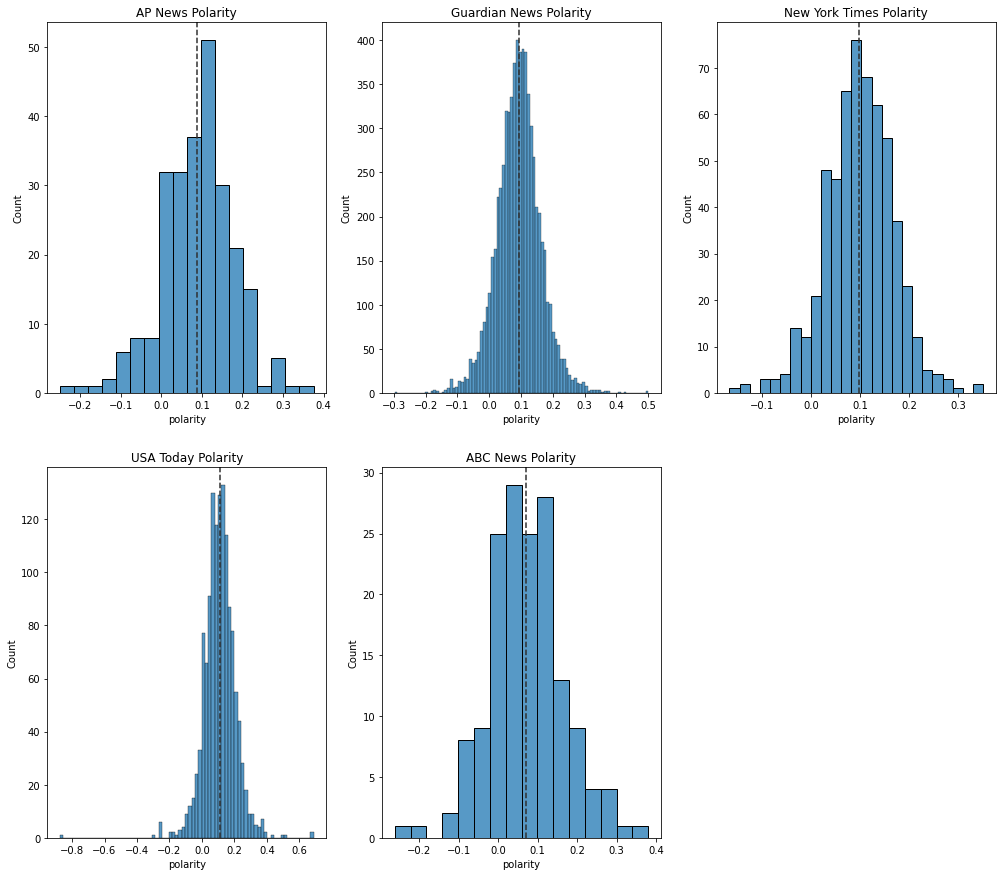

In [45]:
# AP news
plt.subplot(2, 3, 1)
graph1 = sns.histplot(data=ap_df, x='polarity')
graph1.set_title("AP News Polarity")
graph1.axvline(ap_df['polarity'].mean(), color='#2e2e2e', linestyle='--')

# the Guardian
plt.subplot(2, 3, 2)
graph2 = sns.histplot(data=guard_df, x='polarity')
graph2.set_title('Guardian News Polarity')
graph2.axvline(guard_df['polarity'].mean(), color='#2e2e2e', linestyle='--')

# NY Times
plt.subplot(2, 3, 3)
graph3 = sns.histplot(data=nyt_df, x='polarity')
graph3.set_title('New York Times Polarity')
graph3.axvline(nyt_df['polarity'].mean(), color='#2e2e2e', linestyle='--')

# USA Today
plt.subplot(2, 3, 4)
graph4 = sns.histplot(data=usa_df, x='polarity')
graph4.set_title('USA Today Polarity')
graph4.axvline(usa_df['polarity'].mean(), color='#2e2e2e', linestyle='--')

# ABC News
plt.subplot(2, 3, 5)
graph5 = sns.histplot(data=abc_df, x='polarity')
graph5.set_title('ABC News Polarity')
graph5.axvline(abc_df['polarity'].mean(), color='#2e2e2e', linestyle='--')

Next, we take a look at the outliers in the graph for each news source and remove the articles that are irrelevant for our research question.

In [46]:
# the Guardian: filter dataset by the outliers that can be seen on the graph
guard_df[(guard_df['polarity'] > 0.4) | (guard_df['polarity'] < -0.2)]

,headline,date,source,url,text,polarity,subjectivity
2479,Wonderstruck by Brian Selznick - review,2013-01-06 09:00:00+00:00,guard,https://www.theguardian.com/childrens-books-site/2013/jan/06/review-wonderstruck-brian-selznick,This book is about a boy called Ben who lives in Minnesota. He is deaf in one ear and lives with his uncle and aunt. He goes l...,-0.296875,0.625000
2887,Computer learns to understand sign language,2009-07-10 10:00:00+00:00,guard,https://www.theguardian.com/technology/blog/2009/jul/10/computer-sign-language,A woman signing the wood 'good'. Photograph: Turbo/zefa/CorbisHere's something for anyone whose parents ever told them they wo...,0.406061,0.675758
3719,Pick of the week: Rock & pop,2009-04-03 23:01:00+00:00,guard,https://www.theguardian.com/culture/2009/apr/04/north-pop-rock-picks,"David Byrne Sheffield City Hall, Sat 4 AprQuesting Talking Heads oddball and world music proselytiser revisits his collaborati...",0.500000,0.575000
3852,"Books preview: David Lodge, Norwich",2008-10-03 23:12:06+00:00,guard,https://www.theguardian.com/culture/2008/oct/04/centrallistings1,"The writer will talk about his life and work, including his latest novel, Deaf Sentence. Followed by book signing. 7pm, Lectur...",0.500000,0.900000
6661,A thousand years packed into a long weekend in Anglesey,2000-01-02 00:50:22+00:00,guard,https://www.theguardian.com/world/2000/jan/02/millennium.uk13,"We left London with nothing more than a road map, a change of pants, and a suitcase packed with the best things of the past 1,...",0.429016,0.540688


In [47]:
# content seems irrelevant to our discussion of Deaf representation in the media
guard_df.loc[3719, 'text']

"David Byrne Sheffield City Hall, Sat 4 AprQuesting Talking Heads oddball and world music proselytiser revisits his collaborations with Brian Eno, including recent one Everything That Happens Will Happen Today.Bat For Lashes The Ritz, Manchester, Tue 7; Northumbria University Students' Union, Newcastle upon Tyne, Thu 9 Apr Hypnotic folk pop from the multi-instrumentalist and artist. Welcome to kooksville.Fujiya & Miyagi Cargo, London, Wed 8; The Faversham, Leeds, Thu 9; The Deaf Institute, Manchester, Fri 10 Apr Arch but infectious, built on krautrock and venturing somewhere like a space disco. Ace!"

In [48]:
# another irrelevant outlier to remove
guard_df.loc[3852, 'text']

'The writer will talk about his life and work, including his latest novel, Deaf Sentence. Followed by book signing. 7pm, Lecture theatre 1, University of East Anglia, Norwich. Tickets £6. Tel 01603 508050.'

In [49]:
# remove rows 3719, 3852 after looking at the text and deciding it's irrelevant
guard_df = guard_df.drop(3719)
guard_df = guard_df.drop(3852)

In USA Today, we also noticed some irrelevant outliers that we decided to remove.

In [50]:
# USA Today
usa_df[(usa_df['polarity'] < -0.5) | (usa_df['polarity'] > 0.6)]

,headline,date,source,url,text,polarity,subjectivity
523,Prep basketball: Top performers in girls high school basketball,2018-01-27 12:42:00,usa,https://www.usatoday.com/story/sports/high-school/2018/01/27/top-performers-girls-basketball-knoxville-area/1071278001/,"Destiny Haworth, Alcoa: Haworth scored 14 points in the 58-28 win against Scott County.Katie Bean, Alcoa: Bean had a double-do...",0.687879,0.377778
624,125 pets get a new leash on life in Oregon,2018-09-08 19:53:00,usa,https://www.usatoday.com/story/news/2018/09/08/125-pets-get-new-leash-life-oregon/1240205002/,A mother terrier with her litter of five-day-old puppies and a deaf dog named Hazel were among the 108 dogs and 17 cats that a...,-0.875000,1.000000
1192,IC preschool graduation,2014-06-01 16:29:00,usa,https://www.usatoday.com/story/news/2014/06/01/ic-preschool-graduation/9842891/,PORT CLINTON – Students in the preschool program at Immaculate Conception School Preschool graduated.Under the direction of Ma...,0.675000,0.775000


In [51]:
# we are not considering sports news as part of our data
usa_df.loc[523, 'text']

'Destiny Haworth, Alcoa: Haworth scored 14 points in the 58-28 win against Scott County.Katie Bean, Alcoa: Bean had a double-double with 12 points 10 rebounds in the 37-32 loss to Fulton.Maci Houser, Anderson County: Houser scored 12 points in the 59-25 loss to Oak Ridge.Larriana Bullard, Austin-East: Bullard scored 21 points in the 48-37 loss to Kingston.Trinity Lee, Bearden: Lee scored 15 points in the 55-12 win over West.Evie DePetro, Carter: DePetro scored 11 points eight assists and three steals in the 64-49 win over Union County.Sarah Irwin, Carter: Irwin scored 13 points, 17 rebounds, four assists and two steals in the win over Union County.Zarria Clark, Carter: Clark scored 10 points and had seven rebounds in the win against Union County.Megan Miller, Cosby: Miller scored 19 points in the 59-15 win over Tennessee School for the Deaf. Gracee Dishman, Cumberland County: Dishman scored 38 points in the 76-51 win against Grundy.Kiara Wilson, Cumberland County: Wilson scored 15 poin

In [52]:
usa_df.loc[624, 'text']

'A mother terrier with her litter of five-day-old puppies and a deaf dog named Hazel were among the 108 dogs and 17 cats that arrived in Salem Saturday from high-kill shelters in Oklahoma and will soon be up for adoption.This was the 16th flight organized by Fetch Fido a Flight, an organization that transports animals from those high-kill shelters to Oregon where they find a reprieve from euthanasia.Each flight costs about $17,000, paid for by donations. The organization hopes to grow to support one or two flights every month."Dogs are being euthanized because we can\'t get a plane out," said Carole Weber, board secretary of Fetch Fido a Flight. "(Oklahoma shelters) are so backed up, it\'s brutal."After landing in Salem, the cats and dogs were driven to SafeHaven Humane Society south of Albany.  Contact the reporter at cradnovich@statesmanjournal.com or 503-399-6864, or follow him on Twitter at @CDRadnovich'

In [53]:
usa_df = usa_df.drop(523)
usa_df = usa_df.drop(624)

Next, we graphed the distributions of the variable subjectivity, where 0 is least subjective and 1 is most subjective, again split up by news source and with dotted lines to indicate the mean.

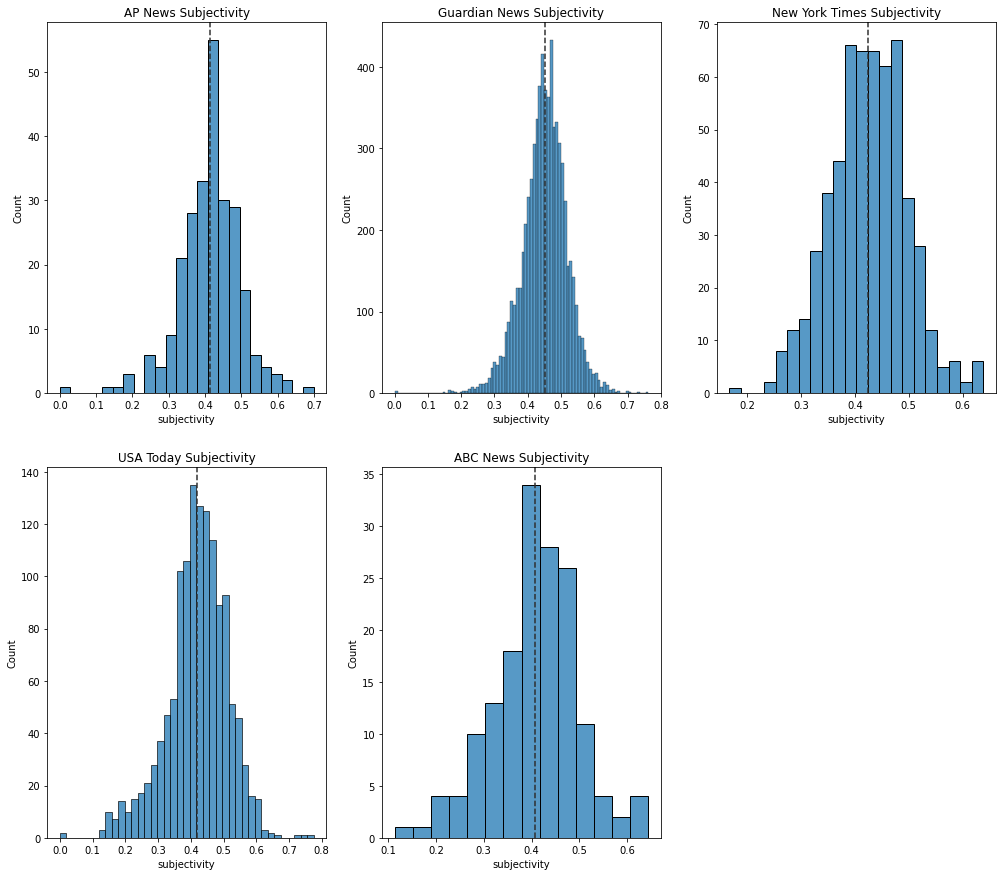

In [54]:
plt.subplot(2, 3, 1)
graph1 = sns.histplot(data=ap_df, x='subjectivity')
graph1.set_title("AP News Subjectivity")
graph1.axvline(ap_df['subjectivity'].mean(), color='#2e2e2e', linestyle='--')

plt.subplot(2, 3, 2)
graph2 = sns.histplot(data=guard_df, x='subjectivity')
graph2.set_title('Guardian News Subjectivity')
graph2.axvline(guard_df['subjectivity'].mean(), color='#2e2e2e', linestyle='--')

plt.subplot(2, 3, 3)
graph3 = sns.histplot(data=nyt_df, x='subjectivity')
graph3.set_title('New York Times Subjectivity')
graph3.axvline(nyt_df['subjectivity'].mean(), color='#2e2e2e', linestyle='--')

plt.subplot(2, 3, 4)
graph4 = sns.histplot(data=usa_df, x='subjectivity')
graph4.set_title('USA Today Subjectivity')
graph4.axvline(usa_df['subjectivity'].mean(), color='#2e2e2e', linestyle='--')


plt.subplot(2, 3, 5)
graph5 = sns.histplot(data=abc_df, x='subjectivity')
graph5.set_title('ABC News Subjectivity')
graph5.axvline(abc_df['subjectivity'].mean(), color='#2e2e2e', linestyle='--')

Looking at the subjectivity distributions, we again check for the most notable outliers and remove irrelevant articles to make the distribution curves more normal.

In [55]:
# AP News
ap_df[ap_df['subjectivity'] < 0.1]

,headline,date,source,url,text,polarity,subjectivity
54,Ómicron trastoca el regreso a las escuelas en EEUU | AP News,2022-01-03 22:02:33+00:00,ap,https://apnews.com/article/noticias-cccc488dc1f210238013cd014571b909,Algunos sistemas escolares de Estados Unidos ampliaron sus vacaciones el lunes o volvieron a impartir clases por internet debi...,0.0,0.0


In [56]:
# remove because we are only considering articles in English
ap_df = ap_df.drop(54)

Next, we want to explore the relationship between polarity and subjectivity in different news sources by making line plots with a fitted regression line. 

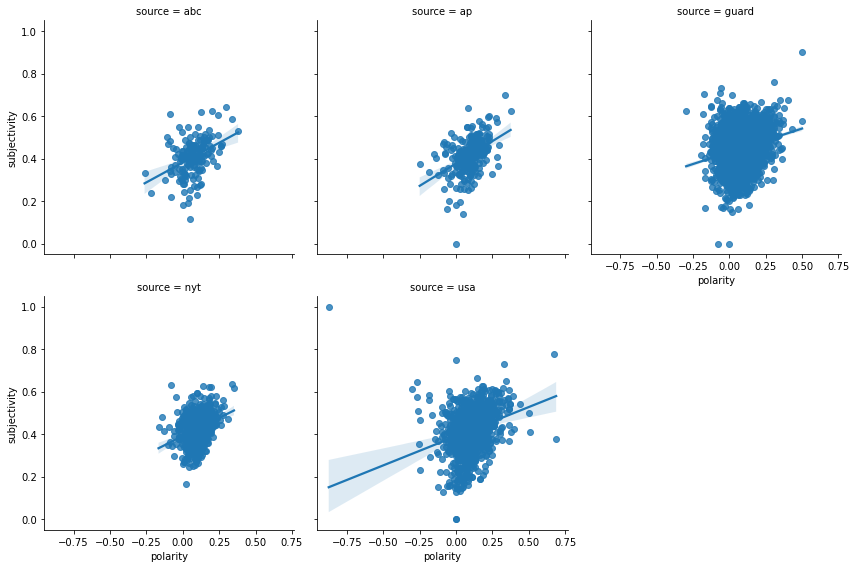

In [57]:
graph = sns.lmplot(x='polarity', y='subjectivity', col='source', data=combined_df, height=4, col_wrap=3)

## Keyword frequencies

Another thing we explored with the data is finding frequencies of certain keywords relevant to our research, such as words for the Deaf community with positive connotations (hard of hearing, Deaf) and those with negative connotations (deaf, mute, hearing impaired).

In [58]:
# make a defaultdict holding all the articles in one string, separated by news source
# like a bag of words
allwords = defaultdict(lambda: "") # make a defaultdict where keys that you access are a given a default value

for i in range(len(df_list)):
    for article in df_list[i]['text']:
        allwords[i] += article
        
# allwords

In [59]:
searchList = ['deaf', 'Deaf', 'mute', 'deaf and dumb', 'hearing impaired', 'hard of hearing']  # our search words
freqsDict = {}    # will hold key, value pairs of (index of the source, frequency list of the terms in that specific source)

for i in range(len(allwords)):
    source = allwords[i]
    freqsList = []
    for term in searchList:
        freqsList.append(source.count(term))
    freqsDict[i] = freqsList

freqsDict

{0: [211, 55, 5, 4, 9, 12],
 1: [444, 90, 8, 1, 25, 29],
 2: [10033, 1852, 510, 87, 95, 413],
 3: [4545, 1084, 29, 2, 92, 116],
 4: [2335, 937, 40, 1, 92, 294]}

In [60]:
# turn freqsDict into a pandas DataFrame for easier reading
terms = pd.DataFrame(data=freqsDict)
terms.index = searchList
terms.columns = ['abc', 'ap', 'guard', 'nyt', 'usa']
terms

,abc,ap,guard,nyt,usa
deaf,211,444,10033,4545,2335
Deaf,55,90,1852,1084,937
mute,5,8,510,29,40
deaf and dumb,4,1,87,2,1
hearing impaired,9,25,95,92,92
hard of hearing,12,29,413,116,294


In [61]:
# get how many words for each news source to proportionalize & account for the fact that some news sources have more articles
news_size = [len(allwords[i]) for i in allwords]
news_size

[671802, 994363, 42985734, 2784962, 6079397]

In [62]:
# proportionalize for each number in the dataframe
for i in range(len(terms.columns)):
    source = terms.columns[i]
    terms[source] = terms[source] / news_size[i]

terms

,abc,ap,guard,nyt,usa
deaf,0.000314,0.000447,0.000233,1.631979e-03,3.840841e-04
Deaf,0.000082,0.000091,0.000043,3.892333e-04,1.541271e-04
mute,0.000007,0.000008,0.000012,1.041307e-05,6.579600e-06
deaf and dumb,0.000006,0.000001,0.000002,7.181427e-07,1.644900e-07
hearing impaired,0.000013,0.000025,0.000002,3.303456e-05,1.513308e-05
hard of hearing,0.000018,0.000029,0.000010,4.165227e-05,4.836006e-05


Next, we visualized these frequencies to see if there were any trends.

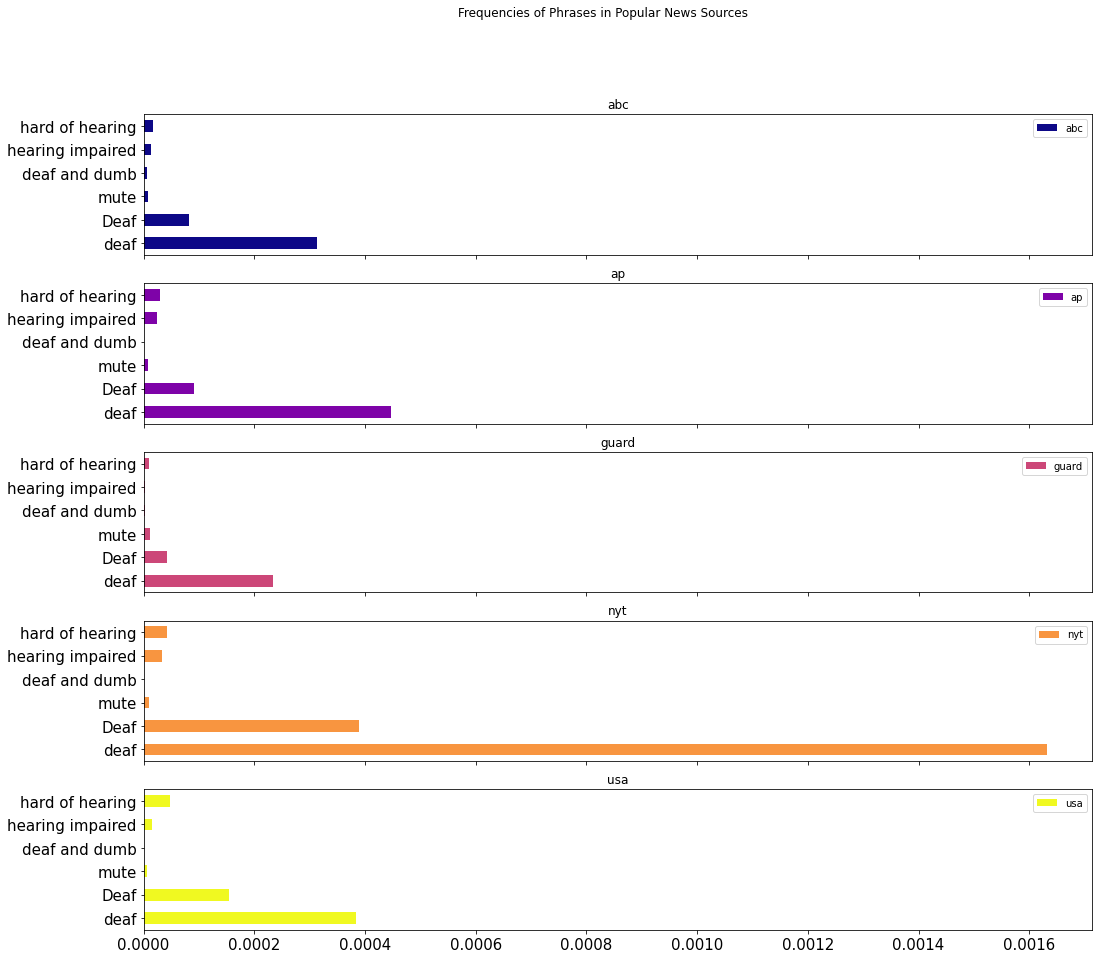

In [63]:
# visualization
plot_freqs = terms.plot(kind="barh", stacked=True, title="Frequencies of Phrases in Popular News Sources", colormap="plasma",
                       fontsize=15, subplots=True)

## TF-IDF Exploration

### Top Keywords

We can use TF-IDF techniques to extrapolate keywords from a text. We can see which words are the most impactful to given documents.

We will be dividing our articles up into documents based on their news source and year they were published in.

In [64]:
# Dividing up our text data into combined strings by source and year
documents = defaultdict(lambda: defaultdict(str))

for _, _, _, source, _, text, _, _, year in combined_df.itertuples():
    documents[source][year] += text

We will be using the sklearn library to process these documents into their TF-IDFs, and need them in a list format.

Here we convert our dictionary into a list of strings, and preserve the keys of the dictionary in a separate list called document_names

In [65]:
corpus = []
document_names = []
for source in documents.keys():
    for year in documents[source].keys():
        corpus.append(documents[source][year])
        document_names.append((source, year))

In [66]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(corpus)
words = list(vectorizer.get_feature_names_out())

Now that we have our TF-IDFs in X, we want to look to see what the most significant words in each document are.

Here we find the top 10 keywords for each document and add them into a new dictionary: top_tfidfs.

In [67]:
top_tfidfs = defaultdict(lambda: defaultdict(list))
for tfidfs, (source, year) in zip(X.toarray(), document_names):
    sorted_tfidfs = tfidfs.argsort()[:-11:-1]
    
    for index in sorted_tfidfs:
        top_tfidfs[source][year].append(words[index])

In [68]:
top_tfidfs['guard'][2021]

['photograph',
 'people',
 'covid',
 'one',
 'said',
 'says',
 'film',
 'first',
 'us',
 'uk']

In [69]:
# Getting a list of all years present in our dataset
all_years = set()
for source in top_tfidfs.keys():
    all_years = all_years.union(set(top_tfidfs[source].keys()))
all_years = list(all_years)
all_years.sort()

Now that we have the top keywords for each source for each year, we can print them out. We decided to only print the top 5 keywords of each source in each year to keep the representation readable.

In [70]:
for year in all_years:
    print(f'\n--- Year {year} ---')
    for source in top_tfidfs.keys():
        if year in top_tfidfs[source]:
            print(f'{source}: {top_tfidfs[source][year][:5]}')


--- Year 1981 ---
nyt: ['deaf', 'bellitz', 'mr', 'lawhorn', 'said']

--- Year 1982 ---
nyt: ['deaf', 'handicapped', 'said', 'school', 'amy']

--- Year 1983 ---
nyt: ['deaf', 'theater', 'hearing', 'said', 'times']

--- Year 1984 ---
nyt: ['deaf', 'schwartzberg', 'said', 'times', 'hearing']

--- Year 1985 ---
ap: ['pickett', 'said', 'ricco', 'adamson', 'jewish']
guard: ['fowles', 'maggot', 'travellers', 'ayscough', 'fanny']
nyt: ['shamal', 'deaf', 'said', 'mr', 'hearing']

--- Year 1986 ---
nyt: ['deaf', 'said', 'hearing', 'mr', 'nolan']

--- Year 1987 ---
nyt: ['deaf', 'koenigsberg', 'said', 'mr', 'students']

--- Year 1988 ---
nyt: ['deaf', 'zinser', 'said', 'spilman', 'gallaudet']

--- Year 1989 ---
guard: ['tiananmen', 'deng', 'peking', 'soldiers', 'peng']
nyt: ['deaf', 'said', 'people', 'times', 'tami']

--- Year 1990 ---
ap: ['posse', 'minniecheske', 'tigerton', 'faa', 'said']
guard: ['pink', 'mr', 'fg', 'geraghty', 'mrs']
nyt: ['deaf', 'rewolinski', 'hearing', 'said', 'mr']

--- 

### Importance of Keywords

We looked at the top keywords for entire years, but we might also want to track how significant different keywords are for all articles.

For this we're going to have each article be a separate document in our corpus. We will then be able to graph the TF-IDF scores for different keywords over time.

In [71]:
corpus = []
for text in combined_df['text']:
    corpus.append(text)

In [72]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(corpus)

X is a sparse matrix where every document in our corpus is a row, and every column represents a word. There is a column for every different word in the corpus (around 150,000) and the value in a given column represents the TF-IDF value of the word for the given article. This is equivalent to the significance of the keyword in the article. If the keyword isn't present in an article the TF-IDF will just be 0.

We start by getting the column index of different keywords we want to track

In [73]:
words = list(vectorizer.get_feature_names_out())

disabled_index = words.index('disabled')
culture_index = words.index('culture')
deaf_index = words.index('deaf')
cochlear_index = words.index('cochlear')
handicapped_index = words.index('handicapped')
art_index = words.index('art')

We can then take those columns and add them back into our dataframe

In [74]:
combined_df['disabled'] = X[:, disabled_index].toarray()
combined_df['culture'] = X[:, culture_index].toarray()
combined_df['deaf'] = X[:, deaf_index].toarray()
combined_df['cochlear'] = X[:, cochlear_index].toarray()
combined_df['handicapped'] = X[:, handicapped_index].toarray()
combined_df['art'] = X[:, art_index].toarray()

We can now graph the distribution of significance for each keyword

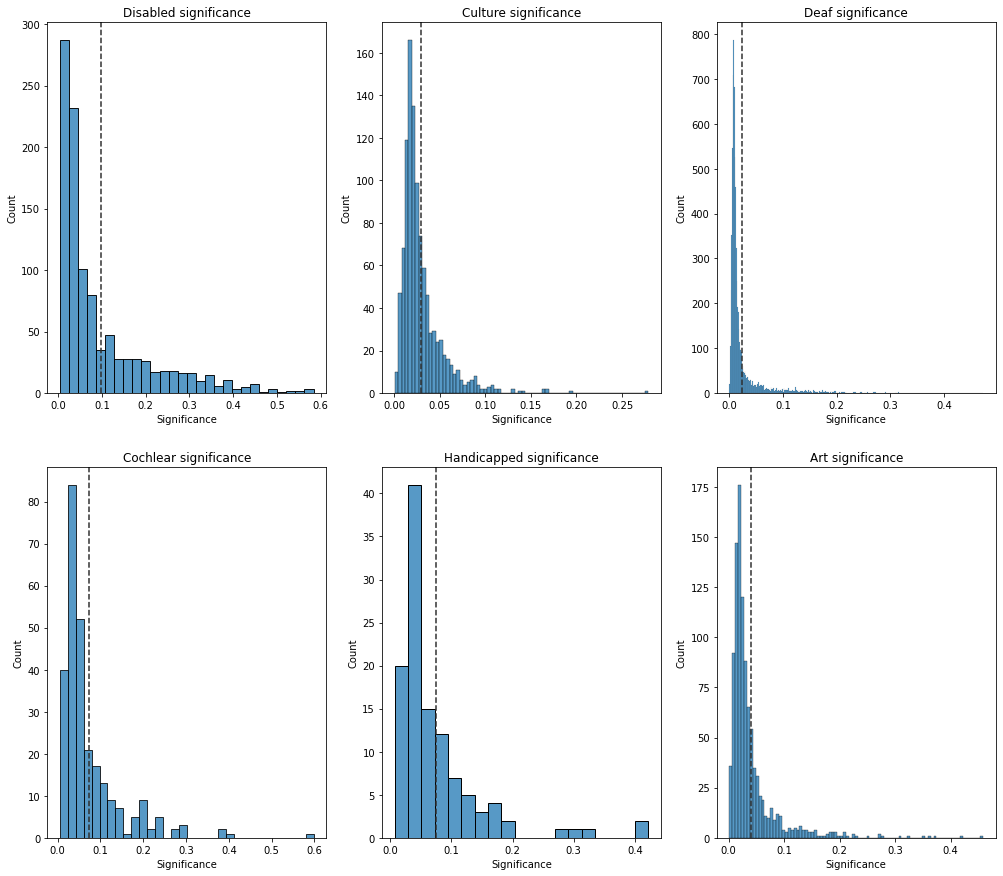

In [75]:
plt.subplot(2, 3, 1)
graph1 = sns.histplot(data=combined_df[combined_df['disabled'] > 0], x='disabled')
graph1.set_title("Disabled significance")
graph1.set_xlabel('Significance')
graph1.axvline(combined_df.loc[combined_df['disabled'] > 0, 'disabled'].mean(), color='#2e2e2e', linestyle='--')

plt.subplot(2, 3, 2)
graph2 = sns.histplot(data=combined_df[combined_df['culture'] > 0], x='culture')
graph2.set_title("Culture significance")
graph2.set_xlabel('Significance')
graph2.axvline(combined_df.loc[combined_df['culture'] > 0, 'culture'].mean(), color='#2e2e2e', linestyle='--')

plt.subplot(2, 3, 3)
graph3 = sns.histplot(data=combined_df[combined_df['deaf'] > 0], x='deaf')
graph3.set_title("Deaf significance")
graph3.set_xlabel('Significance')
graph3.axvline(combined_df.loc[combined_df['deaf'] > 0, 'deaf'].mean(), color='#2e2e2e', linestyle='--')

plt.subplot(2, 3, 4)
graph4 = sns.histplot(data=combined_df[combined_df['cochlear'] > 0], x='cochlear')
graph4.set_title("Cochlear significance")
graph4.set_xlabel('Significance')
graph4.axvline(combined_df.loc[combined_df['cochlear'] > 0, 'cochlear'].mean(), color='#2e2e2e', linestyle='--')

plt.subplot(2, 3, 5)
graph5 = sns.histplot(data=combined_df[combined_df['handicapped'] > 0], x='handicapped')
graph5.set_title("Handicapped significance")
graph5.set_xlabel('Significance')
graph5.axvline(combined_df.loc[combined_df['handicapped'] > 0, 'handicapped'].mean(), color='#2e2e2e', linestyle='--')

plt.subplot(2, 3, 6)
graph6 = sns.histplot(data=combined_df[combined_df['art'] > 0], x='art')
graph6.set_title("Art significance")
graph6.set_xlabel('Significance')
graph6.axvline(combined_df.loc[combined_df['art'] > 0, 'art'].mean(), color='#2e2e2e', linestyle='--')

It appears as though the significance distribution for each keyword is fairly similar. Handicapped, cochlear, and disabled stand out as having more significance generally when they appear.

We can also check the significance of each term over time

Text(0, 0.5, 'Significance')

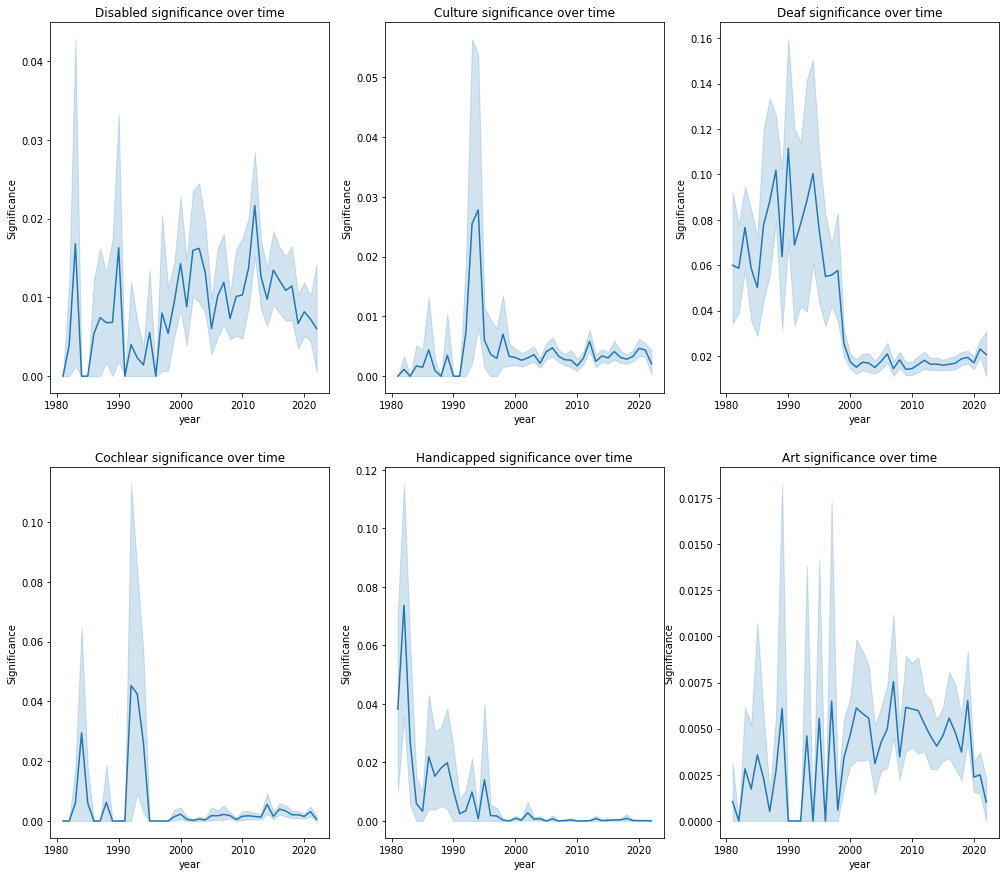

In [76]:
plt.subplot(2, 3, 1)
graph1 = sns.lineplot(data=combined_df, x='year', y='disabled')
graph1.set_title("Disabled significance over time")
graph1.set_ylabel('Significance')

plt.subplot(2, 3, 2)
graph2 = sns.lineplot(data=combined_df, x='year', y='culture')
graph2.set_title("Culture significance over time")
graph2.set_ylabel('Significance')

plt.subplot(2, 3, 3)
graph3 = sns.lineplot(data=combined_df, x='year', y='deaf')
graph3.set_title("Deaf significance over time")
graph3.set_ylabel('Significance')

plt.subplot(2, 3, 4)
graph4 = sns.lineplot(data=combined_df, x='year', y='cochlear')
graph4.set_title("Cochlear significance over time")
graph4.set_ylabel('Significance')

plt.subplot(2, 3, 5)
graph5 = sns.lineplot(data=combined_df, x='year', y='handicapped')
graph5.set_title("Handicapped significance over time")
graph5.set_ylabel('Significance')

plt.subplot(2, 3, 6)
graph6 = sns.lineplot(data=combined_df, x='year', y='art')
graph6.set_title("Art significance over time")
graph6.set_ylabel('Significance')

Disabled as a keyword is interesting in how it grew in signifiance until around 2013 at which point it began waning in significance. A similar phenomenon has appeared to happen with art as a keyword.

Culture appears to have spiked in significance in the early 1990s and to then have settled into a higher plateau of significance since then.

Cochlear and handicapped both appear to be dominated by a handful of articles before 2000 and to have had little significance since.

Finally deaf as a keyword had a major fall in significance in 2000, but since then has appeared to have had a slow growth in significance.

One final comparison of keyword significance is to see if there is any correlation between significance for different keywords

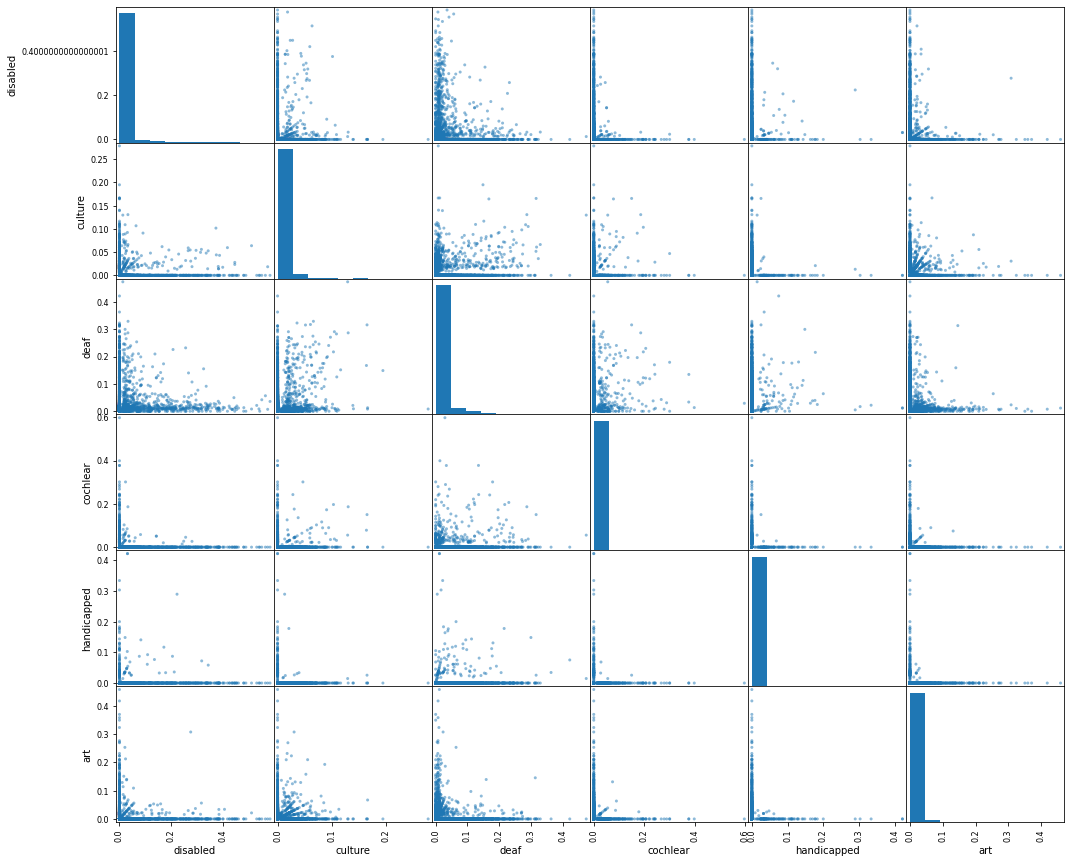

In [77]:
fig1 = pd.plotting.scatter_matrix(frame=combined_df[['disabled', 'culture', 'deaf', 'cochlear', 'handicapped', 'art']])